# SUALBSP-I: Parser and Gurobi Model
This notebook loads `.alb` instances and builds a Gurobi model to minimize the number of stations (Type-I) with sequence-dependent setup times.

Workflow:
1. Parse an instance file.
2. Inspect the parsed data.
3. Build the optimization model.
4. Solve and print the schedule.
5. Plot the station workloads.


In [20]:
from __future__ import annotations

from dataclasses import dataclass
from pathlib import Path
from typing import Dict, Iterable, List, Tuple

import gurobipy as gp
from gurobipy import GRB

import matplotlib.pyplot as plt


In [21]:
@dataclass
class SUALBInstance:
    """Container for a SUALBSP instance (extended with state-based setups)."""
    n_tasks: int
    cycle_time: int
    task_times: Dict[int, int]
    precedences: List[Tuple[int, int]]

    # Classical SUALBSP (pair-based)
    setup_forward: Dict[Tuple[int, int], int]
    setup_backward: Dict[Tuple[int, int], int]

    # NEW: state-based (Markov-style) setup model
    n_states: int
    states: Dict[int, str]
    state_transitions: Dict[Tuple[int, int], int]
    setup_state_forward: Dict[Tuple[int, int], int]

    # NEW: setup between cycles (end_state -> next init_state)
    setup_state_cycle: Dict[Tuple[int, int], int]


def _parse_section(lines: Iterable[str]) -> Dict[str, List[str]]:
    """Parse sections delimited by <section> headers."""
    sections: Dict[str, List[str]] = {}
    current = None
    for raw in lines:
        line = raw.strip()
        if not line:
            continue
        if line.startswith("<") and line.endswith(">"):
            current = line.strip("<>").strip()
            sections[current] = []
            continue
        if current is None:
            continue
        sections[current].append(line)
    return sections


def parse_alb_file(path: Path) -> SUALBInstance:
    """Load a `.alb` file into structured Python data."""
    sections = _parse_section(path.read_text().splitlines())

    # ---- basics ----
    n_tasks = int(sections["number of tasks"][0])
    cycle_time = int(sections["cycle time"][0])

    # ---- task times ----
    task_times: Dict[int, int] = {}
    for entry in sections["task times"]:
        task, duration = entry.split()
        task_times[int(task)] = int(duration)

    # ---- precedences ----
    precedences: List[Tuple[int, int]] = []
    for entry in sections.get("precedence relations", []):
        i, j = entry.split(",")
        precedences.append((int(i), int(j)))

    # ---- classical SUALBSP setups (optional) ----
    setup_forward: Dict[Tuple[int, int], int] = {}
    for entry in sections.get("setup times forward", []):
        i, rest = entry.split(",")
        j, t = rest.split(":")
        setup_forward[(int(i), int(j))] = int(t)

    setup_backward: Dict[Tuple[int, int], int] = {}
    for entry in sections.get("setup times backward", []):
        i, rest = entry.split(",")
        j, t = rest.split(":")
        setup_backward[(int(i), int(j))] = int(t)

    # ---- state model (all optional, defaults=0/empty) ----
    n_states = int(sections.get("number of states", ["0"])[0])

    states: Dict[int, str] = {}
    for entry in sections.get("states", []):
        parts = entry.split(maxsplit=1)
        if not parts:
            continue
        sid = int(parts[0])
        name = parts[1] if len(parts) > 1 else f"STATE_{sid}"
        states[sid] = name

    # from_state,task:to_state
    state_transitions: Dict[Tuple[int, int], int] = {}
    for entry in sections.get("state transitions", []):
        left, right = entry.split(":")
        s, task = left.split(",")
        state_transitions[(int(s), int(task))] = int(right)

    # state,task:setup_time (forward setups)
    setup_state_forward: Dict[Tuple[int, int], int] = {}
    for entry in sections.get("setup times state forward", []):
        left, t = entry.split(":")
        s, task = left.split(",")
        setup_state_forward[(int(s), int(task))] = int(t)

    # -------------------------------------------------
    # NEW: end_state -> next_cycle_start_state
    # -------------------------------------------------
    setup_state_cycle: Dict[Tuple[int, int], int] = {}
    for entry in sections.get("setup times state cycle", []):
        left, t = entry.split(":")
        s_end, s_start = left.split(",")
        setup_state_cycle[(int(s_end), int(s_start))] = int(t)

    return SUALBInstance(
        n_tasks=n_tasks,
        cycle_time=cycle_time,
        task_times=task_times,
        precedences=precedences,
        setup_forward=setup_forward,
        setup_backward=setup_backward,
        n_states=n_states,
        states=states,
        state_transitions=state_transitions,
        setup_state_forward=setup_state_forward,
        setup_state_cycle=setup_state_cycle,
    )


In [22]:
# Example: parse an instance (no optimization yet)
instance_path = Path('DataSets/MiniSet2_Extension.alb')
instance = parse_alb_file(instance_path)

print("=== INSTANCE SUMMARY ===")
print(f"Tasks: {instance.n_tasks}")
print(f"Cycle time: {instance.cycle_time}")
print(f"Task times entries: {len(instance.task_times)}")
print(f"Precedence arcs: {len(instance.precedences)}")

# Classical pair-based setups
print(f"Forward setups (pair-based): {len(instance.setup_forward)}")
print(f"Backward setups (pair-based): {len(instance.setup_backward)}")

# --- State model info ---
print("\n--- State-based setup model ---")
print(f"Number of states: {instance.n_states}")

if instance.n_states > 0:
    print(f"State transitions: {len(instance.state_transitions)}")
    print(f"Forward setups (state,task): {len(instance.setup_state_forward)}")
    print(f"Cycle transition setups (end→start): {len(instance.setup_state_cycle)}")
else:
    print("State model inactive (n_states = 0)")

# optional: limit max number of stations
max_stations = None


=== INSTANCE SUMMARY ===
Tasks: 20
Cycle time: 25
Task times entries: 20
Precedence arcs: 21
Forward setups (pair-based): 0
Backward setups (pair-based): 0

--- State-based setup model ---
Number of states: 2
State transitions: 40
Forward setups (state,task): 40
Cycle transition setups (end→start): 4


In [23]:
# Basic sets and parameters
tasks = list(instance.task_times.keys())
n = instance.n_tasks
cycle = instance.cycle_time
ub_stations = max_stations or n
stations = list(range(1, ub_stations + 1))

# States (for the extended model)
state_ids = list(instance.states.keys())  # e.g. [1, 2, ...]


# -------------------------
# Model and decision variables
# -------------------------
model = gp.Model("SUALBSP-I_with_states")

# Task-to-station assignment
x = model.addVars(tasks, stations, vtype=GRB.BINARY, name="x")
# Station active?
u = model.addVars(stations, vtype=GRB.BINARY, name="u")

# Pairwise ordering (i before j on station k)
z = model.addVars(tasks, tasks, stations, vtype=GRB.BINARY, name="z")

# First / last task on each station
f = model.addVars(tasks, stations, vtype=GRB.BINARY, name="first")
l = model.addVars(tasks, stations, vtype=GRB.BINARY, name="last")

# Backward pair (classic last → first) – nur für Fallback-Modell
b = model.addVars(tasks, tasks, stations, vtype=GRB.BINARY, name="backward")

# Position (MTZ)
p = model.addVars(tasks, stations, vtype=GRB.INTEGER, lb=1, ub=n, name="pos")


# -------------------------
# Assignment constraints
# -------------------------
model.addConstrs((x.sum(i, "*") == 1 for i in tasks), name="assign_once")
model.addConstrs((x.sum("*", k) <= n * u[k] for k in stations), name="use_station")


# -------------------------
# First / Last consistency
# -------------------------
model.addConstrs((f.sum("*", k) == u[k] for k in stations), name="one_first_per_station")
model.addConstrs((l.sum("*", k) == u[k] for k in stations), name="one_last_per_station")
model.addConstrs((f[i, k] <= x[i, k] for i in tasks for k in stations), name="first_only_if_assigned")
model.addConstrs((l[i, k] <= x[i, k] for i in tasks for k in stations), name="last_only_if_assigned")


# -------------------------
# Pairwise ordering
# -------------------------
model.addConstrs((z[i, j, k] <= x[i, k] for i in tasks for j in tasks for k in stations),
                 name="order_only_if_assigned_i")
model.addConstrs((z[i, j, k] <= x[j, k] for i in tasks for j in tasks for k in stations),
                 name="order_only_if_assigned_j")

model.addConstrs(
    (z[i, j, k] + z[j, i, k] <= x[i, k] + x[j, k]
     for i in tasks for j in tasks if i < j for k in stations),
    name="order_upper"
)

model.addConstrs(
    (z[i, j, k] + z[j, i, k] >= x[i, k] + x[j, k] - 1
     for i in tasks for j in tasks if i < j for k in stations),
    name="order_lower"
)


# -------------------------
# MTZ ordering
# -------------------------
big_m = n
model.addConstrs((p[i, k] >= 1 * f[i, k] for i in tasks for k in stations), name="first_pos_lb")
model.addConstrs((p[i, k] <= 1 + (n - 1) * (1 - f[i, k]) for i in tasks for k in stations),
                 name="first_pos_ub")

model.addConstrs((p[i, k] >= n * l[i, k] for i in tasks for k in stations), name="last_pos_lb")
model.addConstrs((p[i, k] <= n + (n - 1) * (1 - l[i, k]) for i in tasks for k in stations),
                 name="last_pos_ub")

model.addConstrs(
    (p[i, k] - p[j, k] + big_m * z[i, j, k]
     <= big_m - 1 + (1 - x[i, k]) * big_m + (1 - x[j, k]) * big_m
     for i in tasks for j in tasks if i != j for k in stations),
    name="mtz_order"
)


# -------------------------
# First precedes all, last has no successor
# -------------------------
model.addConstrs(
    (z[i, j, k] >= f[i, k] + x[j, k] - 1
     for i in tasks for j in tasks if i != j for k in stations),
    name="first_precedes_all"
)

model.addConstrs(
    (z[i, j, k] <= 1 - l[j, k] + x[i, k]
     for i in tasks for j in tasks if i != j for k in stations),
    name="last_followed_by_none"
)


# -------------------------
# Backward setup (classic pair-based) – nur für Fallback ohne States
# -------------------------
model.addConstrs((b[i, j, k] <= l[i, k] for i in tasks for j in tasks for k in stations),
                 name="backward_last")
model.addConstrs((b[i, j, k] <= f[j, k] for i in tasks for j in tasks for k in stations),
                 name="backward_first")
model.addConstrs((b[i, j, k] >= l[i, k] + f[j, k] - 1 for i in tasks for j in tasks for k in stations),
                 name="backward_iff")


# -------------------------
# Precedence
# -------------------------
station_index = {i: gp.quicksum(k * x[i, k] for k in stations) for i in tasks}

model.addConstrs(
    (station_index[i] <= station_index[j] for i, j in instance.precedences),
    name="precede_station"
)

model.addConstrs(
    (z[i, j, k] >= x[i, k] + x[j, k] - 1
     for i, j in instance.precedences for k in stations),
    name="precede_order_same_station"
)


# ======================================================================
#  STATE-BASED SETUP MODEL (automatic initial state + cycle setups)
# ======================================================================
if instance.n_states > 0 and len(state_ids) > 0:

    adj = model.addVars(tasks, tasks, stations, vtype=GRB.BINARY, name="adj")
    state_before = model.addVars(tasks, stations, state_ids, vtype=GRB.BINARY, name="state_before")

    # ---- Startzustand je Station (vom Modell gewählt) ----
    init_state = model.addVars(stations, state_ids, vtype=GRB.BINARY, name="init_state")

    # genau ein Startzustand je aktiver Station
    model.addConstrs(
        (gp.quicksum(init_state[k, s] for s in state_ids) == u[k] for k in stations),
        name="one_init_state_per_station"
    )

    # Sicherheit: nur wenn Station aktiv
    model.addConstrs(
        (init_state[k, s] <= u[k] for k in stations for s in state_ids),
        name="init_state_only_if_active"
    )

    # erster Task erbt Startzustand
    for i in tasks:
        for k in stations:
            for s in state_ids:
                model.addConstr(
                    state_before[i, k, s] >= init_state[k, s] + f[i, k] - 1,
                    name=f"first_uses_init_state_{i}_{k}_{s}"
                )

    # ---- Endzustand je Station ----
    end_state = model.addVars(stations, state_ids, vtype=GRB.BINARY, name="end_state")

    model.addConstrs(
        (gp.quicksum(end_state[k, s] for s in state_ids) == u[k] for k in stations),
        name="one_end_state_per_station"
    )

    model.addConstrs(
        (end_state[k, s] <= u[k] for k in stations for s in state_ids),
        name="end_state_only_if_active"
    )

    # ---- Adjazenz & Transitionen ----
    model.addConstrs(
        (gp.quicksum(adj[i, j, k] for i in tasks) + f[j, k] == x[j, k]
         for j in tasks for k in stations),
        name="adj_predecessor_or_first"
    )

    model.addConstrs(
        (gp.quicksum(adj[i, j, k] for j in tasks) + l[i, k] == x[i, k]
         for i in tasks for k in stations),
        name="adj_successor_or_last"
    )

    model.addConstrs(
        (adj[i, j, k] <= z[i, j, k] for i in tasks for j in tasks for k in stations),
        name="adj_implies_order"
    )

    # jede zugeordnete Aufgabe hat genau einen Zustand davor
    model.addConstrs(
        (gp.quicksum(state_before[i, k, s] for s in state_ids) == x[i, k]
         for i in tasks for k in stations),
        name="one_state_per_task"
    )

    # Zustandsübergänge innerhalb der Station
    for k in stations:
        for i in tasks:
            for j in tasks:
                if i == j:
                    continue
                for s_prev in state_ids:
                    s_next = instance.state_transitions.get((s_prev, i), None)
                    if s_next is None:
                        continue
                    model.addConstr(
                        state_before[j, k, s_next] >= state_before[i, k, s_prev] + adj[i, j, k] - 1,
                        name=f"state_trans_{i}_{j}_{k}_{s_prev}_to_{s_next}"
                    )

    # Endzustand aus letztem Task ableiten
    for k in stations:
        for i in tasks:
            for s_prev in state_ids:
                s_next = instance.state_transitions.get((s_prev, i), None)
                if s_next is None:
                    continue
                model.addConstr(
                    end_state[k, s_next] >= state_before[i, k, s_prev] + l[i, k] - 1,
                    name=f"end_state_{k}_{i}_{s_prev}_to_{s_next}"
                )

    # ---- NEU: Cycle-State-Paare (end_state → init_state) ----
    cycle_state_pair = model.addVars(
        stations, state_ids, state_ids,
        vtype=GRB.BINARY, name="cycle_state_pair"
    )

    for k in stations:
        for s_end in state_ids:
            for s_start in state_ids:
                # Linearisation von end_state * init_state
                model.addConstr(
                    cycle_state_pair[k, s_end, s_start] <= end_state[k, s_end],
                    name=f"cycle_pair_le_end_{k}_{s_end}_{s_start}"
                )
                model.addConstr(
                    cycle_state_pair[k, s_end, s_start] <= init_state[k, s_start],
                    name=f"cycle_pair_le_init_{k}_{s_end}_{s_start}"
                )
                model.addConstr(
                    cycle_state_pair[k, s_end, s_start]
                    >= end_state[k, s_end] + init_state[k, s_start] - 1,
                    name=f"cycle_pair_ge_sum_{k}_{s_end}_{s_start}"
                )

    # ---- Cycle time mit state-basierten Setups (OHNE backward-state) ----
    for k in stations:
        processing = gp.quicksum(instance.task_times[i] * x[i, k] for i in tasks)

        # Forward-Setups: setup(state, task) vor der Ausführung von task
        forward_state_setups = gp.quicksum(
            instance.setup_state_forward.get((s, i), 0) * state_before[i, k, s]
            for i in tasks for s in state_ids
        )

        # KEIN separater backward_state_setup mehr!

        # Transition-Setups zwischen Zyklen (Ende → nächster Start)
        cycle_transition_setups = gp.quicksum(
            instance.setup_state_cycle.get((s_end, s_start), 0)
            * cycle_state_pair[k, s_end, s_start]
            for s_end in state_ids for s_start in state_ids
        )

        model.addConstr(
            processing
            + forward_state_setups
            + cycle_transition_setups
            <= cycle * u[k],
            name=f"cycle_state_{k}"
        )

else:
    # Fallback: klassisches pair-basiertes Modell
    forward_default = 0
    backward_default = 0
    for k in stations:
        processing = gp.quicksum(instance.task_times[i] * x[i, k] for i in tasks)
        forward_setups = gp.quicksum(
            instance.setup_forward.get((i, j), forward_default) * z[i, j, k]
            for i in tasks for j in tasks if i != j
        )
        backward_setups = gp.quicksum(
            instance.setup_backward.get((i, j), backward_default) * b[i, j, k]
            for i in tasks for j in tasks
        )
        model.addConstr(
            processing + forward_setups + backward_setups <= cycle * u[k],
            name=f"cycle_pair_{k}"
        )


# -------------------------
# Objective
# -------------------------
model.setObjective(gp.quicksum(u[k] for k in stations), GRB.MINIMIZE)


In [24]:
model.update()
model

<gurobi.Model MIP instance SUALBSP-I_with_states: 99701 constrs, 26580 vars, Parameter changes: Username=(user-defined), LicenseID=2732783>

In [25]:
model.optimize()

Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (win64 - Windows 11.0 (26100.2))

CPU model: AMD Ryzen 5 5600H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 99701 rows, 26580 columns and 297460 nonzeros
Model fingerprint: 0xbe240385
Variable types: 0 continuous, 26580 integer (26180 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 2e+01]
  RHS range        [1e+00, 6e+01]
Presolve removed 40733 rows and 8907 columns
Presolve time: 1.52s
Presolved: 58968 rows, 17673 columns, 174491 nonzeros
Variable types: 0 continuous, 17673 integer (17278 binary)
Found heuristic solution: objective 3.0000000

Deterministic concurrent LP optimizer: primal and dual simplex (primal and dual model)
Showing primal log only...

Root relaxation presolved: 58968 rows, 17673 columns, 174491 nonzeros

Concurrent spin time: 0.02

In [26]:
# Print results with setup times
if model.status == GRB.OPTIMAL:
    print("Objective value (min #stations):", model.objVal)
    print("Cycle Time C:", cycle)
    print("")

    for k in stations:
        tasks_here = [i for i in tasks if x[i, k].X > 0.5]
        if not tasks_here:
            continue

        seq = sorted(tasks_here, key=lambda i: p[i, k].X)

        print(f"=== Station {k} ===")
        t = 0

        # ----------------------------------------------------
        # CASE 1: STATE-BASED OUTPUT
        # ----------------------------------------------------
        if instance.n_states > 0:

            for idx, op in enumerate(seq):

                # state before op
                active_state = None
                for s in state_ids:
                    var = model.getVarByName(f"state_before[{op},{k},{s}]")
                    if var is not None and var.X > 0.5:
                        active_state = s

                dur = instance.task_times[op]
                setup = instance.setup_state_forward.get((active_state, op), 0)

                start = t
                print(
                    f"Task {op:2d}: "
                    f"state={active_state}, "
                    f"setup={setup:2d}, "
                    f"proc={dur:2d}, "
                    f"start={start:3d}, end={start + setup + dur:3d}"
                )

                t += setup + dur

        # ----------------------------------------------------
        # CASE 2: CLASSIC PAIR-BASED OUTPUT
        # ----------------------------------------------------
        else:

            for idx, op in enumerate(seq):
                dur = instance.task_times[op]
                start = t
                end = t + dur

                print(
                    f"Task {op:2d}: processing {dur:2d}  "
                    f"(start={start:3d}, end={end:3d})"
                )

                t = end

                if idx < len(seq) - 1:
                    nxt = seq[idx + 1]
                    s = instance.setup_forward.get((op, nxt), 0)

                    if s > 0:
                        print(f"   → setup forward {s:2d} (between {op} → {nxt})")
                        t += s

        print(f"Total time on station {k}: {t}")

else:
    print("No solution found")


Objective value (min #stations): 3.0
Cycle Time C: 25

=== Station 1 ===
Task 20: state=2, setup= 0, proc= 5, start=  0, end=  5
Task 19: state=1, setup= 0, proc= 2, start=  5, end=  7
Task 16: state=1, setup= 0, proc= 3, start=  7, end= 10
Task 11: state=2, setup= 0, proc= 2, start= 10, end= 12
Task  7: state=2, setup= 0, proc= 2, start= 12, end= 14
Task 18: state=2, setup= 0, proc= 4, start= 14, end= 18
Task 15: state=2, setup= 0, proc= 2, start= 18, end= 20
Task 12: state=2, setup= 0, proc= 5, start= 20, end= 25
Total time on station 1: 25
=== Station 2 ===
Task 17: state=2, setup= 0, proc= 6, start=  0, end=  6
Task 13: state=1, setup= 0, proc= 3, start=  6, end=  9
Task  9: state=2, setup= 0, proc= 6, start=  9, end= 15
Task 14: state=1, setup= 0, proc= 4, start= 15, end= 19
Task 10: state=2, setup= 0, proc= 3, start= 19, end= 22
Total time on station 2: 22
=== Station 3 ===
Task  6: state=2, setup= 0, proc= 3, start=  0, end=  3
Task  8: state=2, setup= 0, proc= 4, start=  3, end

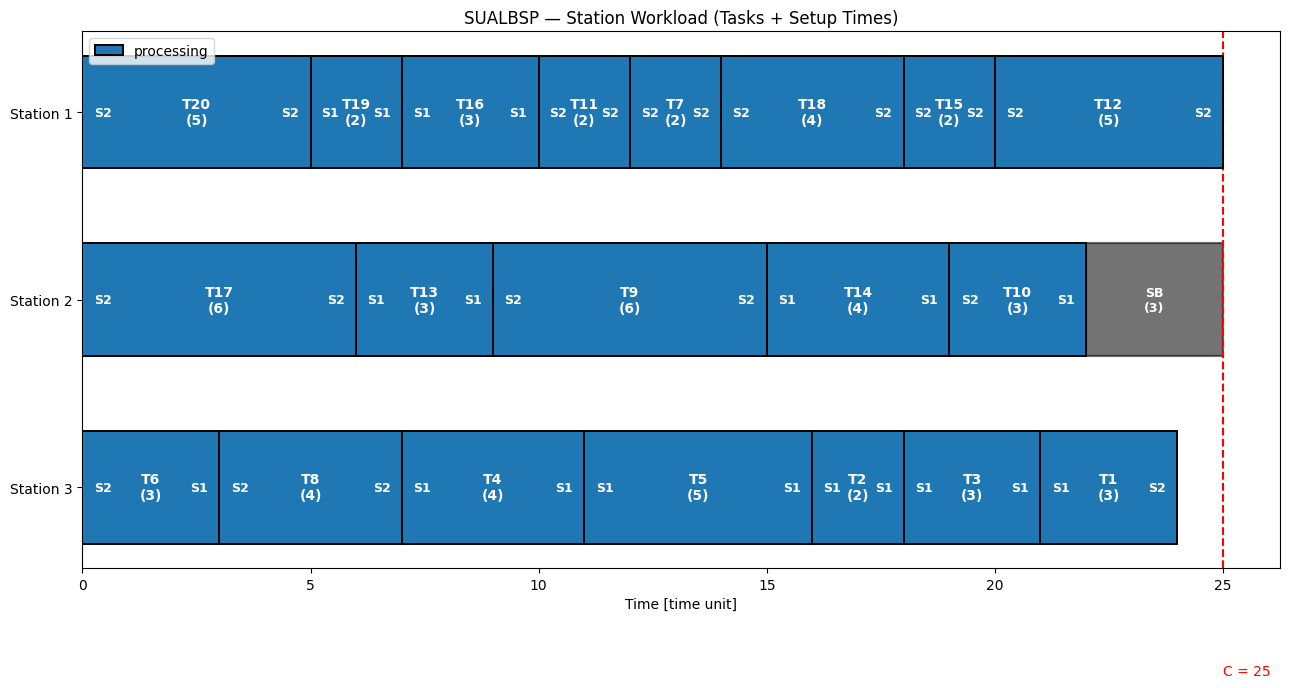

In [29]:
if model.SolCount == 0:
    print("⚠️ No solution — skipping plot.")
else:
    ordered_station_tasks = {}

    for k in stations:
        tasks_here = [i for i in tasks if x[i, k].X > 0.5]
        if tasks_here:
            ordered_station_tasks[k] = sorted(tasks_here, key=lambda i: p[i, k].X)

    # -> höher & mehr Abstand oben
    fig, ax = plt.subplots(figsize=(13, 1.6 * len(ordered_station_tasks) + 2))
    plt.subplots_adjust(top=0.76)

    y_labels, y_positions = [], []

    task_color = "#1f77b4"
    setup_color = "#7f7f7f"
    cycle_setup_color = "black"
    bar_height = 0.6

    for row, (k, seq) in enumerate(sorted(ordered_station_tasks.items())):
        y_positions.append(row)
        y_labels.append(f"Station {row + 1}")
        t = 0

        # =========================================================
        # STATE-BASED VIEW
        # =========================================================
        if instance.n_states > 0:

            for idx, op in enumerate(seq):

                # --- active start state
                active_state = None
                for s in state_ids:
                    v = model.getVarByName(f"state_before[{op},{k},{s}]")
                    if v is not None and v.X > 0.5:
                        active_state = s
                        break

                setup = instance.setup_state_forward.get((active_state, op), 0)
                dur = instance.task_times[op]

                # --- setup (forward)
                if setup > 0:
                    ax.barh(
                        row, setup, left=t, height=bar_height,
                        color=setup_color, alpha=0.55,
                        edgecolor="black", linewidth=1.4,
                        label="setup (state-based)" if (row == 0 and idx == 0) else None,
                    )
                    ax.text(
                        t + setup / 2, row, f"S\n({setup})",
                        ha="center", va="center",
                        color="white", fontsize=9, fontweight="bold",
                        clip_on=True,
                    )
                    t += setup

                # --- task bar
                ax.barh(
                    row, dur, left=t, height=bar_height,
                    color=task_color,
                    edgecolor="black", linewidth=1.4, zorder=3,
                    label="processing" if (row == 0 and idx == 0) else None,
                )

                # --- task label
                ax.text(
                    t + dur / 2, row,
                    f"T{op}\n({dur})",
                    ha="center", va="center",
                    color="white", fontsize=10, fontweight="bold",
                    clip_on=True, zorder=4
                )

                # --- state labels INSIDE task bar
                pad = min(0.25, max(0.06, 0.12 * dur))
                fs_state = 9 if dur >= 1.2 else 7

                # start state (left)
                if active_state is not None:
                    ax.text(
                        t + pad, row, f"S{active_state}",
                        ha="left", va="center",
                        color="white", fontsize=fs_state, fontweight="bold",
                        clip_on=True, zorder=4
                    )

                # end state (right)
                state_after = None
                if active_state is not None:
                    state_after = instance.state_transitions.get((active_state, op), None)

                if state_after is not None:
                    ax.text(
                        t + dur - pad, row, f"S{state_after}",
                        ha="right", va="center",
                        color="white", fontsize=fs_state, fontweight="bold",
                        clip_on=True, zorder=4
                    )

                t += dur

            # =====================================================
            # cycle transition setup (backward)
            # =====================================================
            s_end = s_start = None

            for s in state_ids:
                if model.getVarByName(f"end_state[{k},{s}]").X > 0.5:
                    s_end = s
                if model.getVarByName(f"init_state[{k},{s}]").X > 0.5:
                    s_start = s

            cycle_setup = instance.setup_state_cycle.get((s_end, s_start), 0)

            if cycle_setup > 0:
                ax.barh(
                    row, cycle_setup, left=t, height=bar_height,
                    color=cycle_setup_color, alpha=0.55,
                    edgecolor="black", linewidth=1.6,
                    label="cycle setup (backward)" if row == 0 else None,
                )
                ax.text(
                    t + cycle_setup / 2, row,
                    f"SB\n({cycle_setup})",
                    ha="center", va="center",
                    color="white", fontsize=9, fontweight="bold",
                    clip_on=True
                )
                t += cycle_setup

        # =========================================================
        # PAIR-BASED FALLBACK (no states)
        # =========================================================
        else:
            for idx, op in enumerate(seq):
                dur = instance.task_times[op]
                ax.barh(
                    row, dur, left=t, height=bar_height,
                    color=task_color,
                    edgecolor="black", linewidth=1.4, zorder=3,
                    label="processing" if (row == 0 and idx == 0) else None,
                )
                ax.text(
                    t + dur / 2, row,
                    f"T{op}\n({dur})",
                    ha="center", va="center",
                    color="white", fontsize=10, fontweight="bold",
                    clip_on=True
                )
                t += dur

    # --- cycle time line
    ax.axvline(cycle, linestyle="--", linewidth=1.5, color="red")
    ax.text(cycle, len(ordered_station_tasks), f"C = {cycle}", color="red")

    ax.set_yticks(y_positions)
    ax.set_yticklabels(y_labels)
    ax.set_xlabel("Time [time unit]")
    ax.set_title("SUALBSP — Station Workload (Tasks + Setup Times)")
    ax.invert_yaxis()

    handles, labels = ax.get_legend_handles_labels()
    if handles:
        ax.legend()

    plt.tight_layout()
    plt.show()
